# LSTM RNN for GC=F prices prediction

Using a long-short term memory recurrent neural network to predics GOLD prices
retrieved from Yahoo finance.

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import yfinance as yf
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime


### Download GOLD data from yahoo finance

In [2]:
ticker = 'GC=F'
start = datetime(2015, 1, 1)
end = datetime.today() + timedelta(-1)
gold = yf.download(ticker, start, end)
gold

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,1184.000000,1194.500000,1169.500000,1186.000000,1186.000000,138
2015-01-05,1180.300049,1206.900024,1180.099976,1203.900024,1203.900024,470
2015-01-06,1203.500000,1220.000000,1203.500000,1219.300049,1219.300049,97
2015-01-07,1219.199951,1219.199951,1210.599976,1210.599976,1210.599976,29
2015-01-08,1207.000000,1215.699951,1206.300049,1208.400024,1208.400024,92
...,...,...,...,...,...,...
2024-04-15,2362.100098,2384.699951,2326.000000,2365.800049,2365.800049,1801
2024-04-16,2384.000000,2390.800049,2371.399902,2390.800049,2390.800049,41
2024-04-17,2384.199951,2391.399902,2369.300049,2371.699951,2371.699951,37


In [3]:
X = torch.tensor(gold.to_numpy(dtype=float))
y = torch.tensor(gold['Adj Close'].to_numpy(dtype=float)).unsqueeze(dim=1)

### Define the LSTM RNN

In [4]:
class LSTMModel(nn.Module):
    """LSTM RNN model."""
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        num_layers
        ):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            batch_first=True,
            num_layers=num_layers,
            dropout=0.5,
            bias=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """Classical forward pass.

        Args:
            x (_type_): _description_

        Returns:
            _type_: _description_
        """
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).cuda()
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Only take output from the last time step
        return out


### Define training loop

In [5]:

def train(
    model,
    optimiser,
    train_data,
    test_data,
    n_epochs=100,
    loss_fun=nn.MSELoss()
):
    """
    NN training loop. Return is None, but optimises the NN.

    Args_:

        model: The NN (or other) model used for data fit.
        
        optimiser: Optimisation method for backward pass.
        
        train_data: Training set of data from DataLoader.
        
        test_data: Testing set of data from DataLoader..
        
        n_epochs: Number of iterations for the propagation.
        
        loss_fun: Loss function to minimise via back-propagation.

    Returns_:

        None.
        NN is optimised in the process, by adjusting the Arg "model".
    """
    for epoch in range(n_epochs+1):
        # train the neural network one batch at a time
        model.train()
        train_loss = 0
        for data, target in train_data:
            data, target = data.cuda(), target.cuda()
            pred_train = model(data)
            batch_train_loss = loss_fun(pred_train, target)

            train_loss += batch_train_loss.item() * data.size(0)

            optimiser.zero_grad()
            batch_train_loss.backward()
            optimiser.step()
        del data, target, pred_train

        model.eval()
        # validate for each epoch
        test_loss = 0
        with torch.no_grad():
            for data, target in test_data:
                data, target = data.cuda(), target.cuda()
                pred_test = model(data)
                batch_test_loss = loss_fun(pred_test, target)

                test_loss += batch_test_loss.item() * data.size(0)
        del data, target, pred_test

        # print epoch results
        if epoch % 20 == 0:
            print(f'Epoch {epoch}/{n_epochs};', ''*5,
                  f'    Train loss: {train_loss:.3f};', ''*5,
                  f'    Valid loss: {test_loss:.3f}')

        # setup for an early stop
        if epoch == 0:
            last_10 = torch.full((10, 1), float(test_loss)).cuda()
        else:
            last_10[epoch % 10] = test_loss

        # break condition
        condition = (
            # do at least 10 epochs
            epoch > 10
            and (
                # if the loss is stagnating
                abs((test_loss - last_10.mean())/last_10.mean()) < 0.01
                # or significantly worsening
                or test_loss > 1.2*last_10.mean()
                )
        )
        if condition:
            print(f'Break on epoch{epoch}/{n_epochs}', ''*5,
                  f'    Train loss: {train_loss:.3f};', ''*5,
                  f'    Valid loss: {test_loss:.3f}\n')
            break

### Define time prediction plots

Function plotting the time series.

In [6]:
#%%### plotting
def plot_time_predictions(
    ax, predict, target, val_predict, val_target, thresh, thresh2, SUBSEQ_DAYS
    ):

    data_plot = pd.DataFrame(
        np.vstack((predict, target)).T,
        columns=['predict', 'target'],
        index = gold.index[thresh2+SUBSEQ_DAYS:]
    )

    val_plot = pd.DataFrame(
        np.vstack((val_predict, val_target)).T,
        columns=['predict', 'target'],
        index = gold.index[thresh+SUBSEQ_DAYS:thresh2+SUBSEQ_DAYS]
    )

    ax.plot(val_plot.index, val_plot.target, 'k', label='train-target',
            linewidth=1)
    ax.plot(val_plot.index, val_plot.predict, 'r:', label='train-predict',
            linewidth=2)
    
    ax.plot(data_plot.index, data_plot.target, 'g', label='test-target',
            linewidth=1)
    ax.plot(data_plot.index, data_plot.predict, 'b:', label='test-predict',
            linewidth=2)
    ax.legend()

## MAIN LOOP

The main loop here loops through a different number of subsequent days used as
a short term memory in the LSTM.

c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/500;      Train loss: 419.617;      Valid loss: 119.243
Epoch 20/500;      Train loss: 3.830;      Valid loss: 0.188
Break on epoch39/500      Train loss: 0.603;      Valid loss: 0.119

Epoch 0/500;      Train loss: 294.278;      Valid loss: 70.374


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.882;      Valid loss: 0.171
Break on epoch29/500      Train loss: 0.791;      Valid loss: 0.147

Epoch 0/500;      Train loss: 282.418;      Valid loss: 58.700


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.935;      Valid loss: 0.170
Epoch 40/500;      Train loss: 0.760;      Valid loss: 0.128
Break on epoch56/500      Train loss: 0.703;      Valid loss: 0.121

Epoch 0/500;      Train loss: 331.247;      Valid loss: 60.417


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.003;      Valid loss: 0.169
Epoch 40/500;      Train loss: 0.832;      Valid loss: 0.138
Break on epoch49/500      Train loss: 0.794;      Valid loss: 0.135

Epoch 0/500;      Train loss: 315.393;      Valid loss: 50.266


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.017;      Valid loss: 0.183
Epoch 40/500;      Train loss: 0.858;      Valid loss: 0.147
Break on epoch40/500      Train loss: 0.858;      Valid loss: 0.147

Epoch 0/500;      Train loss: 256.585;      Valid loss: 31.828


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.982;      Valid loss: 0.169
Break on epoch35/500      Train loss: 0.851;      Valid loss: 0.153

Epoch 0/500;      Train loss: 409.519;      Valid loss: 65.176


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.072;      Valid loss: 0.180
Break on epoch39/500      Train loss: 0.895;      Valid loss: 0.163

Epoch 0/500;      Train loss: 271.906;      Valid loss: 31.522


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.982;      Valid loss: 0.172
Break on epoch32/500      Train loss: 0.881;      Valid loss: 0.166

Epoch 0/500;      Train loss: 350.323;      Valid loss: 48.996


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 1.084;      Valid loss: 0.191
Break on epoch38/500      Train loss: 0.897;      Valid loss: 0.168



c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/500;      Train loss: 226.210;      Valid loss: 21.160
Epoch 20/500;      Train loss: 0.940;      Valid loss: 0.175
Break on epoch28/500      Train loss: 0.890;      Valid loss: 0.171

Epoch 0/500;      Train loss: 271.712;      Valid loss: 24.935


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.980;      Valid loss: 0.184
Break on epoch29/500      Train loss: 0.915;      Valid loss: 0.178

Epoch 0/500;      Train loss: 247.766;      Valid loss: 24.687


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.929;      Valid loss: 0.176
Break on epoch31/500      Train loss: 0.863;      Valid loss: 0.164

Epoch 0/500;      Train loss: 273.650;      Valid loss: 26.044


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.918;      Valid loss: 0.170
Break on epoch29/500      Train loss: 0.878;      Valid loss: 0.167

Epoch 0/500;      Train loss: 284.483;      Valid loss: 35.847


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.933;      Valid loss: 0.172
Break on epoch27/500      Train loss: 0.888;      Valid loss: 0.174

Epoch 0/500;      Train loss: 251.711;      Valid loss: 25.523


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.864;      Valid loss: 0.160
Break on epoch30/500      Train loss: 0.819;      Valid loss: 0.154

Epoch 0/500;      Train loss: 224.106;      Valid loss: 14.230


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.865;      Valid loss: 0.159
Break on epoch32/500      Train loss: 0.823;      Valid loss: 0.153

Epoch 0/500;      Train loss: 303.118;      Valid loss: 25.787


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.954;      Valid loss: 0.172
Epoch 40/500;      Train loss: 0.825;      Valid loss: 0.152
Break on epoch44/500      Train loss: 0.821;      Valid loss: 0.150



c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/500;      Train loss: 368.734;      Valid loss: 42.134
Epoch 20/500;      Train loss: 0.998;      Valid loss: 0.190
Break on epoch38/500      Train loss: 0.850;      Valid loss: 0.160

Epoch 0/500;      Train loss: 283.048;      Valid loss: 32.336


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.935;      Valid loss: 0.179
Break on epoch31/500      Train loss: 0.887;      Valid loss: 0.169

Epoch 0/500;      Train loss: 334.740;      Valid loss: 49.302


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.934;      Valid loss: 0.178
Break on epoch30/500      Train loss: 0.863;      Valid loss: 0.164

Epoch 0/500;      Train loss: 302.719;      Valid loss: 33.392


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.939;      Valid loss: 0.167
Break on epoch35/500      Train loss: 0.836;      Valid loss: 0.155

Epoch 0/500;      Train loss: 384.128;      Valid loss: 58.051


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.926;      Valid loss: 0.178
Break on epoch33/500      Train loss: 0.862;      Valid loss: 0.158

Epoch 0/500;      Train loss: 300.869;      Valid loss: 35.566


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.917;      Valid loss: 0.162
Break on epoch34/500      Train loss: 0.841;      Valid loss: 0.158

Epoch 0/500;      Train loss: 354.634;      Valid loss: 43.592


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.954;      Valid loss: 0.172
Break on epoch38/500      Train loss: 0.822;      Valid loss: 0.152

Epoch 0/500;      Train loss: 348.040;      Valid loss: 35.502


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.948;      Valid loss: 0.174
Break on epoch38/500      Train loss: 0.846;      Valid loss: 0.159

Epoch 0/500;      Train loss: 287.972;      Valid loss: 31.410


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.933;      Valid loss: 0.164
Break on epoch35/500      Train loss: 0.831;      Valid loss: 0.154

Epoch 0/500;      Train loss: 243.613;      Valid loss: 21.938


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.892;      Valid loss: 0.165
Break on epoch33/500      Train loss: 0.838;      Valid loss: 0.158

Epoch 0/500;      Train loss: 377.007;      Valid loss: 49.063


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.960;      Valid loss: 0.176
Break on epoch35/500      Train loss: 0.854;      Valid loss: 0.162

Epoch 0/500;      Train loss: 328.301;      Valid loss: 36.888


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.912;      Valid loss: 0.166
Break on epoch35/500      Train loss: 0.820;      Valid loss: 0.154

Epoch 0/500;      Train loss: 323.158;      Valid loss: 39.451


c:\Users\alexn\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 20/500;      Train loss: 0.918;      Valid loss: 0.166
Break on epoch34/500      Train loss: 0.821;      Valid loss: 0.152



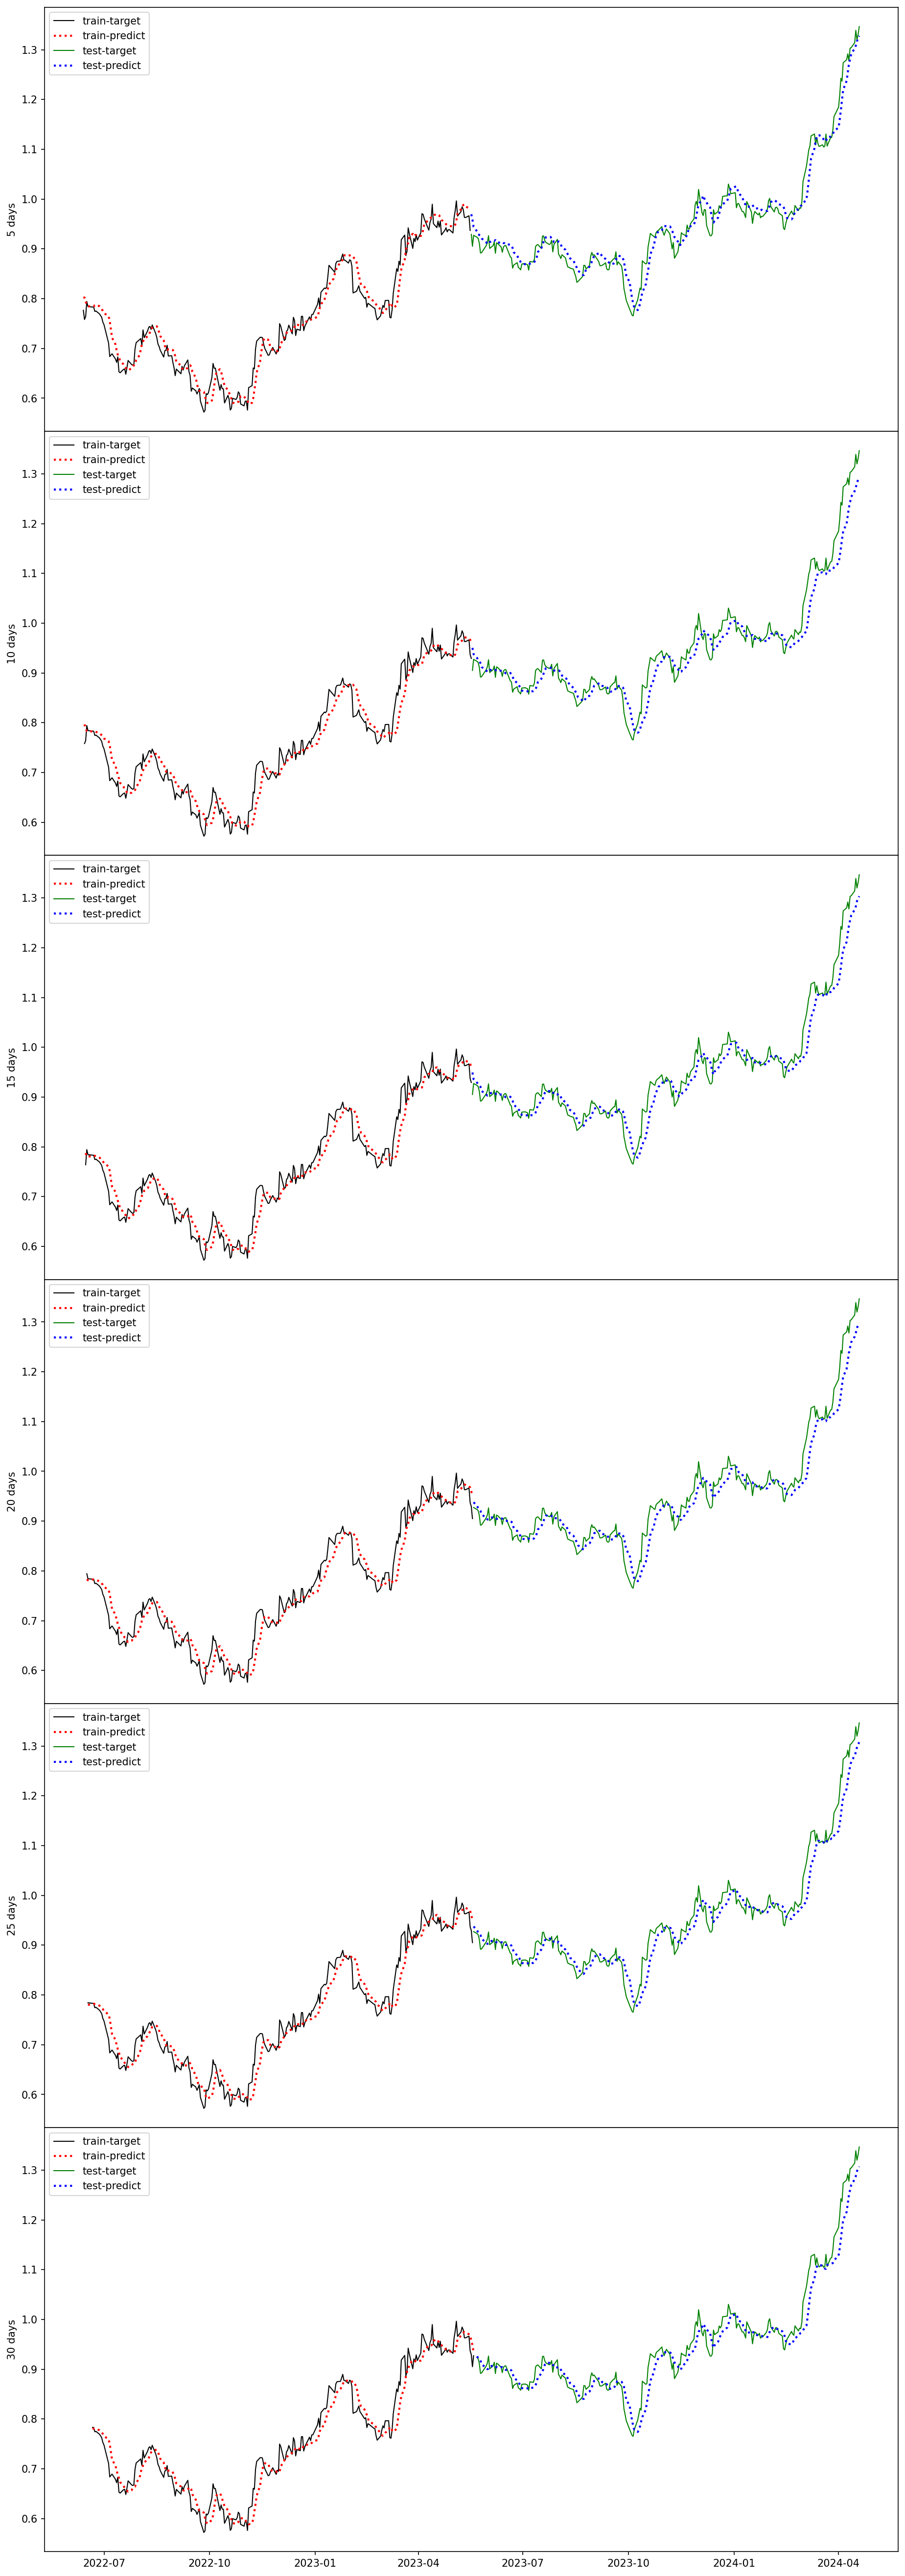

In [7]:
# dataframe to store scores in
scores = pd.DataFrame(columns=['train', 'test'])

# set up to plot time predictions for given number of days
fig, axs = plt.subplots(
    nrows=6,
    ncols=1,
    figsize=(15, 45),
    dpi=150,
    sharex=True,
    sharey=True)

# loops through different number of subsequent days to use
for SUBSEQ_DAYS in range(1, 31):
    data_len = data_len = X.shape[0] - SUBSEQ_DAYS
    num_feat = X.shape[1]
    # threshold to determine train-val-test splits
    thresh = int(data_len*0.8)
    thresh2 = int(data_len*0.9)
        
    # MinMax scaling using only data that will fall into train set
    min, _ = torch.min(X[:thresh], axis=0)
    max, _ = torch.max(X[:thresh], axis=0)

    # MinMax Scaling
    X = (X - min) / (max - min)
    y = (y - min[4]) / (max[4] - min[4])
    
    # create tensors for sequenced data
    seq_X = torch.zeros(size=(data_len, SUBSEQ_DAYS, num_feat))
    seq_y = torch.zeros(size=(data_len, 1))
    # create sequences of subsequent days to feed into the LSTM
    for day in range(data_len):
        # train data from SUBSEQ_DAYS of subsequent days
        seq_X[day] = X[day:day+SUBSEQ_DAYS, :]
        # target one day in advance
        seq_y[day] = y[day+SUBSEQ_DAYS]
        
    # create train/test splits from sequenced data
    train_X, val_X, test_X = \
        seq_X[:thresh], seq_X[thresh:thresh2], seq_X[thresh2:]
    train_y, val_y, test_y = \
        seq_y[:thresh], seq_y[thresh:thresh2], seq_y[thresh2:]
    
    ### DataLoader – Dataset makes responding samples be chosen together, train loader creates batches
    train_dataset = TensorDataset(train_X, train_y)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    val_dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)

    test_dataset = TensorDataset(test_X, test_y)
    test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

    ### instance of model and optimiser, running the train loop
    model = LSTMModel(num_feat, 300, 1, 1).cuda()
    optimiser = optim.Adam(model.parameters(), lr=1e-3)

    train(
        model=model,
        optimiser=optimiser,
        train_data=train_loader,
        test_data=val_loader,
        n_epochs=500,
        loss_fun=nn.MSELoss()
    )
    # create model predictions for train/test sets
    predict = model(test_X.cuda()).detach().cpu().flatten().numpy()
    target = test_y.flatten().numpy()

    val_predict = model(val_X.cuda()).detach().cpu().flatten().numpy()
    val_target = val_y.flatten().numpy()

    train_predict = model(train_X.cuda()).detach().cpu().flatten().numpy()
    train_target = train_y.flatten().numpy()

    scores.loc[SUBSEQ_DAYS, 'train'] = r2_score(train_target, train_predict)
    scores.loc[SUBSEQ_DAYS, 'val'] = r2_score(val_target, val_predict)
    scores.loc[SUBSEQ_DAYS, 'test'] = r2_score(target, predict)
    
    # plot predictions for every 5th day
    if SUBSEQ_DAYS % 5 == 0:
        plot_time_predictions(
            axs[(SUBSEQ_DAYS // 5) - 1], 
            predict, target, val_predict, val_target, thresh, thresh2, SUBSEQ_DAYS
        )
        axs[(SUBSEQ_DAYS // 5) - 1].set_ylabel(f'{SUBSEQ_DAYS} days')

plt.subplots_adjust(hspace=0)

### plot R2 as a function of days

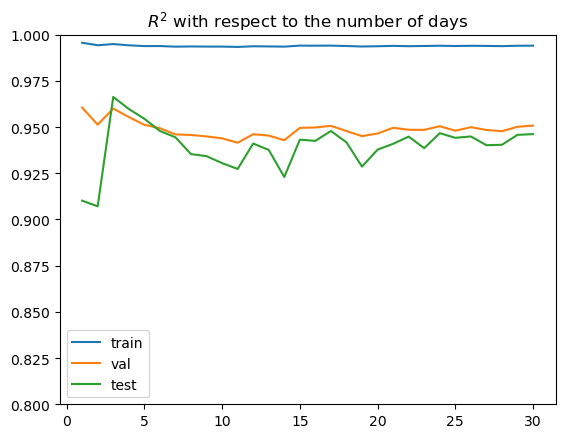

In [8]:
plt.plot(scores.train, label='train')
plt.plot(scores.val, label='val')
plt.plot(scores.test, label='test')
plt.ylim(0.8, 1)
plt.title('$R^2$ with respect to the number of days')
plt.legend()
plt.show()
plt.close()

**Despite the R2 scores looking great, a careful inspection of the time plots reveals, that the trained LSTM does not reliably predict the evolution of the price. It just learned that the future value is going to be very close to the last couple of values and basically just copies the history into the near future.**